In [2]:
# testing in pulling in reynolds creek data from the s3 bucket and producing stats
# jack tarricone
# july 14th 2021

In [13]:
# import libraries
import os  # for chdir, getcwd, path.basename, path.exists
import hvplot.xarray
import pandas as pd # for DatetimeIndex 
import rioxarray
import numpy as np #for log10, mean, percentile, power
import rasterio as rio
from rasterio.plot import show # plotting raster data
from rasterio.plot import show_hist #histograms of raster data

import glob # for listing files in tiff conversion function
import matplotlib.pyplot as plt # for add_subplot, axis, figure, imshow, legend, plot, set_axis_off, set_data,
                                # set_title, set_xlabel, set_ylabel, set_ylim, subplots, title, twinx
    
# from scotts s3read .nb
import json
import os
import hvplot.xarray

In [7]:
# Change to tmp directory and download staged tutorial data
os.chdir('/tmp')

#!aws s3 cp --no-progress s3://snowex-data/tutorial-data/sar/uavsar/ .  --recursive --exclude "*" --include "*tiff"

In [14]:
# set paths to different data we want (lets start with just HH)

In [15]:
# unw
unw_path = 's3://snowex-data/uavsar-project/UAVSAR_images/silver_2020_011_347_0019d/silver_34715_20011-001_20016-002_0019d_s01_L090HH_01.unw.grd.tiff'

In [16]:
# cor
cor_path = 's3://snowex-data/uavsar-project/UAVSAR_images/silver_2020_011_347_0019d/silver_34715_20011-001_20016-002_0019d_s01_L090HH_01.cor.grd.tiff'

In [17]:
# dem
dem_path = 's3://snowex-data/uavsar-project/UAVSAR_images/silver_2020_011_347_0019d/silver_34715_20011-001_20016-002_0019d_s01_L090HH_01.hgt.grd.tiff'

In [18]:
# int
int_path = 's3://snowex-data/uavsar-project/UAVSAR_images/silver_2020_011_347_0019d/silver_34715_20011-001_20016-002_0019d_s01_L090HH_01.int.grd.tiff'

In [19]:
%%bash 
# Set up temporary credentials for GDAL
# https://github.com/OSGeo/gdal/issues/4058
# NOTE: these last for 1 hour
aws sts assume-role-with-web-identity \
 --role-arn $AWS_ROLE_ARN \
 --role-session-name snowex \
 --web-identity-token file://$AWS_WEB_IDENTITY_TOKEN_FILE \
 --duration-seconds 3600 > /tmp/irp-cred.json

# Print out creds    
#echo AWS_REGION="us-west-2"
#echo AWS_ACCESS_KEY_ID="$(cat /tmp/irp-cred.json | jq -r ".Credentials.AccessKeyId")"
#echo AWS_SECRET_ACCESS_KEY="$(cat /tmp/irp-cred.json | jq -r ".Credentials.SecretAccessKey")"
#echo AWS_SESSION_TOKEN="$(cat /tmp/irp-cred.json | jq -r ".Credentials.SessionToken")"

In [20]:
# Use temporary credentials in python (rasterio)

with open('/tmp/irp-cred.json') as f:
    creds = json.load(f)
    AccessKeyId = creds['Credentials']['AccessKeyId']
    SecretAccessKey = creds['Credentials']['SecretAccessKey']
    SessionToken = creds['Credentials']['SessionToken']
    
    # Set environment variables
    os.environ['AWS_ACCESS_KEY_ID'] = AccessKeyId
    os.environ['AWS_SECRET_ACCESS_KEY'] = SecretAccessKey
    os.environ['AWS_SESSION_TOKEN'] = SessionToken

# GDAL env variables https://gdal.org/user/virtual_file_systems.html#vsicurl-http-https-ftp-files-random-access
Env = rio.Env(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR')

In [24]:
# read in cloud based unw data
with Env:
    unw = rioxarray.open_rasterio(unw_path, masked=True).squeeze('band', drop=True)
    
unw.name = os.path.basename(unw_path)
unw

<xarray.DataArray 'silver_34715_20011-001_20016-002_0019d_s01_L090HH_01.unw.grd.tiff' (y: 7662, x: 6855)>
[52523010 values with dtype=float32]
Coordinates:
  * x            (x) float64 -116.9 -116.9 -116.9 ... -116.6 -116.6 -116.6
  * y            (y) float64 43.37 43.37 43.37 43.37 ... 42.95 42.95 42.95 42.95
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [54]:
# cor
with Env:
    cor = rioxarray.open_rasterio(cor_path)
    
cor.name = os.path.basename(cor_path)
cor

<xarray.DataArray 'silver_34715_20011-001_20016-002_0019d_s01_L090HH_01.cor.grd.tiff' (band: 1, y: 7662, x: 6855)>
[52523010 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -116.9 -116.9 -116.9 ... -116.6 -116.6 -116.6
  * y            (y) float64 43.37 43.37 43.37 43.37 ... 42.95 42.95 42.95 42.95
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [58]:
# mask 0 values as NaN's
cor_masked = cor.where(cor != 0)

In [59]:
cor_masked.hvplot.image(rasterize=True, cmap='gray')

:DynamicMap   [band]
   :Image   [y,x]   (silver_34715_20011-001_20016-002_0019d_s01_L090HH_01.cor.grd.tiff)

In [62]:
print(np.mean(cor_masked))
print(np.max(cor_masked))
print(np.min(cor_masked))

<xarray.DataArray 'silver_34715_20011-001_20016-002_0019d_s01_L090HH_01.cor.grd.tiff' ()>
array(0.56591874, dtype=float32)
Coordinates:
    spatial_ref  int64 0
<xarray.DataArray 'silver_34715_20011-001_20016-002_0019d_s01_L090HH_01.cor.grd.tiff' ()>
array(0.9983313, dtype=float32)
Coordinates:
    spatial_ref  int64 0
<xarray.DataArray 'silver_34715_20011-001_20016-002_0019d_s01_L090HH_01.cor.grd.tiff' ()>
array(0.00021129, dtype=float32)
Coordinates:
    spatial_ref  int64 0


In [63]:
q75 = np.percentile(cor_masked, 75)
q25 = np.percentile(cor_masked, 25)
print(q75)
print(q25)

nan
nan


In [66]:
np.count_nonzero(~np.isnan(cor_masked))

28935404

In [67]:
# unw
with Env:
    unw = rioxarray.open_rasterio(unw_path)
    
unw.name = os.path.basename(unw_path)
unw

<xarray.DataArray 'silver_34715_20011-001_20016-002_0019d_s01_L090HH_01.unw.grd.tiff' (band: 1, y: 7662, x: 6855)>
[52523010 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -116.9 -116.9 -116.9 ... -116.6 -116.6 -116.6
  * y            (y) float64 43.37 43.37 43.37 43.37 ... 42.95 42.95 42.95 42.95
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [8]:
### inspect our newly created .tiffs, and create named objects for each data type. We'll use these new obects in the next step

# amplitude from the first acquisition
for amp1 in glob.glob("*amp1.grd.tiff"):
    print(amp1)
    
# amplitude from the second acquisition
for amp2 in glob.glob("*amp2.grd.tiff"):
    print(amp2)

# coherence
for cor in glob.glob("*cor.grd.tiff"):
    print(cor)

# unwrapped phase
for unw in glob.glob("*unw.grd.tiff"):
    print(unw)

# dem used in processing
for dem in glob.glob("*hgt.grd.tiff"):
    print(dem)

uticam_21003_21004-002_21013-003_0034d_s01_L090HH_01.cor.grd.tiff
uticam_21003_21004-002_21013-003_0034d_s01_L090HH_01.unw.grd.tiff
uticam_21003_21004-002_21013-003_0034d_s01_L090HH_01.hgt.grd.tiff


Inspect the meta data the rasters using the rio (shorthand for rasterio) ```profile``` function.

In [9]:
unw_rast = rio.open(unw)
meta_data = unw_rast.profile
print(meta_data)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 15461, 'height': 15639, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(5.556e-05, 0.0, -110.55389916,
       0.0, -5.556e-05, 47.27761524), 'tiled': False, 'interleave': 'band'}


## Opening and plotting the raw UAVSAR raster files
We now have our five different data sets: the two amplitude files, coherence, unwrapped phased, and the DEM. We will not be working the actual interferogram (.int) file because it contains complex numbers that don't work in the Python packages being used.

Here we will open a raster files using the ```rio.open()``` function. We'll then create a simple plot using the ```rio``` ```show()``` function.

### Amp 1

In [34]:
amp1_rast = rio.open(amp1) #open raster
fig, ax = plt.subplots(figsize = (10,7)) #define figure size
ax.set_title("Amplitude 1",fontsize = 16); #set title and font size
show((amp1_rast, 1), cmap = 'Blues', vmin = 0, vmax = 1); #plot, set color type and range

RasterioIOError: grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.amp1.grd.tiff: No such file or directory

### Amp 2

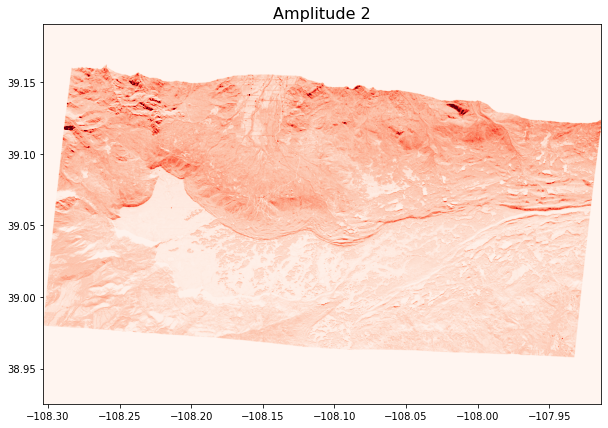

In [10]:
amp2_rast = rio.open(amp2)
fig, ax = plt.subplots(figsize = (10,7))
ax.set_title("Amplitude 2",fontsize = 16);
show((amp2_rast, 1), cmap = 'Reds', vmin = 0, vmax = 1);

### Coherence

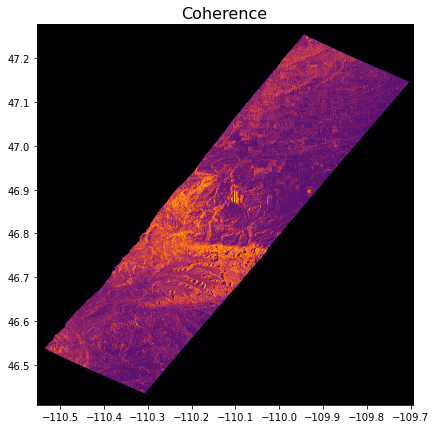

In [10]:
cor_rast = rio.open(cor)
fig, ax = plt.subplots(figsize = (10,7))
ax.set_title("Coherence",fontsize = 16);
show((cor_rast, 1), cmap = 'inferno', vmin = 0, vmax = 1);

### DEM
Now we'll make a quick histogram using ```rio``` ```show_hist()``` to check what we should set the bounds of the color scale to.

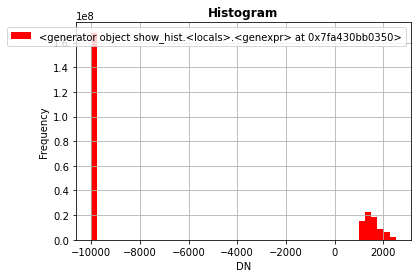

In [11]:
dem_rast = rio.open(dem)
show_hist(dem_rast, bins = 50)

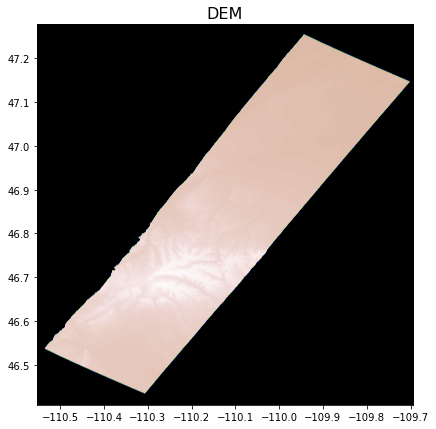

In [12]:
fig, ax = plt.subplots(figsize = (10,7))
ax.set_title("DEM",fontsize = 16);
show((dem_rast, 1), cmap = 'gist_earth'); #estimated these values from the histogram

### Unwrapped Phase
Another histogram for the color bounds, and note the large amount of 0's values. This is will become imporant in the next few steps.

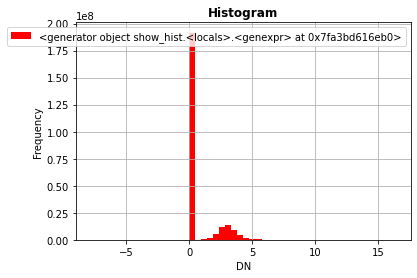

In [13]:
unw_rast = rio.open(unw)
show_hist(unw_rast, bins = 50)

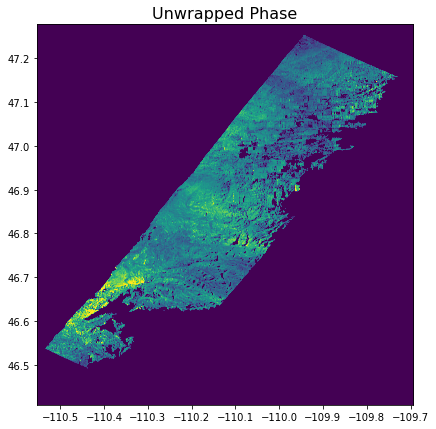

In [14]:
unw_rast = rio.open(unw)
fig, ax = plt.subplots(figsize = (10,7))
ax.set_title("Unwrapped Phase",fontsize = 16);
show((unw_rast, 1), cmap = 'viridis', vmin = 1, vmax = 5); # info from histogram

## Formatting the data for visualization
The plots of the raw data need some work. Some fotmatting is necessary to visualize the data clearly. UAVSAR uses "0" as it's no data value (not the best practice in general) for amplitude, coherence, and unwrapped phase. For the DEM -10000 is the no data value. Using -9999 or another value that is obviously not actual data is a better practice with spatial data to limit confusion. We'll convert these no data values to NaN (Not a Number) which will remove the boarders around data, and in data lost the unwrapping in the UNW file.

### Amplitude formatting
For the two amplitude files we need to do two things. Convert from the linear amplitude scale to decibel (dB) and change the 0 values to NaN. To do this we'll convert our raster file to an ```np.array``` to manipulate it. Note that when we convert the raster data to an array, the spatial coordinates are lost and it no longer plots the x and y scales at longitude and latitude values. For our purposes this okay, but you would need to convert back to a .tiff if you wanted to save the file to use in ArcGIS or QGIS.

In [16]:
# amp1 
# open raster as a data array
with rio.open(amp1) as amp1_raw:
    amp1_array = amp1_raw.read(1) #open raster as an array

# convert all 0's to nan
amp1_array[amp1_array == 0] = np.nan # convert all 0's to NaN's

# convert to dB
amp1_dB = 10.0 * np.log10(amp1_array) # convert to the dB scale

# amp2 
with rio.open(amp2) as amp2_raw:
    amp2_array = amp2_raw.read(1)
    
amp2_array[amp2_array == 0] = np.nan

amp2_dB = 10.0 * np.log10(amp2_array)

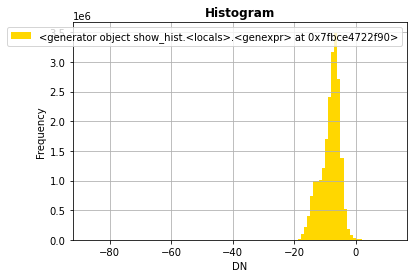

In [17]:
show_hist(amp2_dB, bins = 100)

Instead of using the ```rio.show()``` function, we'll try out the ```matplotlib``` (we are calling ```plt```) ```im.show()``` style of plotting to implement a color scale.

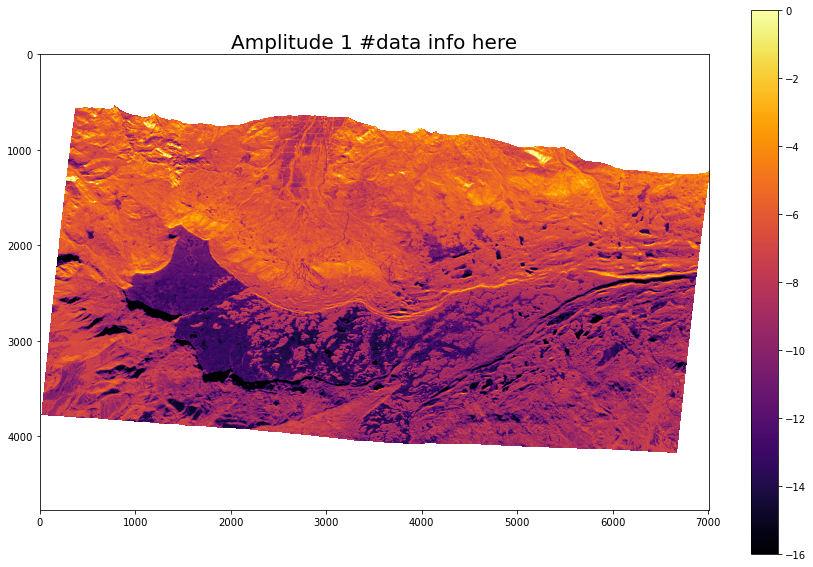

In [19]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.set_title("Amplitude 1 #data info here", fontsize= 20) #title and font size
amp2_plot = ax.imshow(amp2_dB, cmap='inferno',vmin=-16, vmax=0) #set bounds and color map

# add legend
colorbar = fig.colorbar(amp2_plot, ax=ax) #add color bar
plt.show()

Now we'll create a function called ```show_two_images()``` to plot two images at once. The function inputs are a data array, color map name, and a plot title for both images. It uses ```np.nanpercentile()``` to automatically set the color scale bounds, but you can also set them manually.

In [20]:
# function for showing two images using matplotlib
plt.rcParams.update({'font.size': 12}) # set fontsize
def show_two_images(img1, img2, col1, col2, title1, title2, vmin1=None, vmax1=None, vmin2=None, vmax2=None):

    fig = plt.figure(figsize=(20, 20))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    # auto setting axis limits
    if vmin1 == None:
        vmin1 = np.nanpercentile(img1, 1)
    if vmax1 == None:
        vmax1 = np.nanpercentile(img1, 99)
    
    # plot image
    masked_array1 = np.ma.array(img1, mask=np.isnan(0)) #mask for 0
    plt1 = ax1.imshow(masked_array1, cmap=col1, vmin=vmin1, vmax=vmax1, interpolation = 'nearest') #fixes NaN problem
    ax1.set_title(title1)
    ax1.xaxis.set_label_text('Linear stretch Min={} Max={}'.format(vmin1, vmax1))
        
    # add color scale
    colorbar = fig.colorbar(plt1, ax=ax1, fraction=0.03, pad=0.04)
    
     # auto setting axis limits
    if vmin2 == None:
        vmin2 = np.nanpercentile(img2, 1)
    if vmax2 == None:
        vmax2 = np.nanpercentile(img2, 99)
    
    # plot image
    masked_array2 = np.ma.array(img2, mask=np.isnan(0)) #mask for 0
    plt2 = ax2.imshow(masked_array2, cmap=col2, vmin=vmin2, vmax=vmax2, interpolation = 'nearest')
    ax2.set_title(title2)
    ax2.xaxis.set_label_text('Linear stretch Min={} Max={}'.format(vmin2, vmax2))
    colorbar = fig.colorbar(plt2, ax=ax2, fraction=0.03, pad=0.04)
    plt.show()


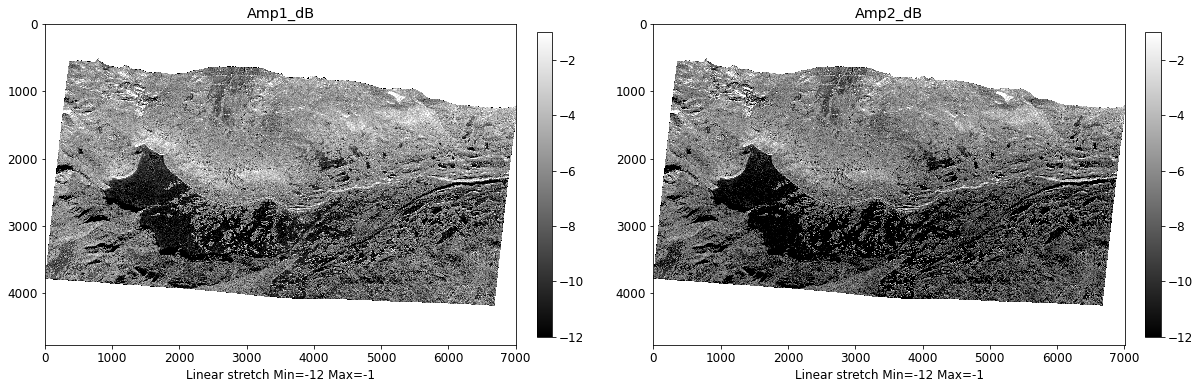

In [21]:
# plot both amplitude images

show_two_images(amp1_dB, amp2_dB, 'gray', 'gray', 'Amp1_dB', 'Amp2_dB', -12,-1,-12,-1)

### Coherence, Unwrapped Phase, DEM
For these three data types, we only need to convert no data values (0) to NaN.

In [15]:
with rio.open(cor) as cor_raw:
    cor_array = cor_raw.read(1)

cor_array[cor_array == 0] = np.nan # convert all 0's to nan

# unw
with rio.open(unw) as unw_raw:
    unw_array = unw_raw.read(1)
    
unw_array[unw_array == 0] = np.nan

# dem
with rio.open(dem) as dem_raw:
    dem_array = dem_raw.read(1)
    
dem_array[dem_array == -10000] = np.nan #different no data value

Checking to see if it worked by comparing ```unw_rast``` which still includes 0's to ```unw_array``` where we changed them to NaN.

In [ ]:
show_hist(unw_rast, bins = 100) 
show_hist(unw_array, bins = 100)

In [ ]:
plt.rcParams.update({'font.size': 12}) # set fontsize
show_two_images(dem_array, unw_array, 'gist_earth', 'viridis', 'DEM (m)', 'UNW (radians)')

Let's plot the UNW raster larger so we can get a better look at the detail.

In [ ]:
plt.rcParams.update({'font.size': 16}) # increase plot font size for larger plot
fig, ax = plt.subplots(figsize=(40, 20))

masked_array = np.ma.array(unw_array, mask = np.isnan(0)) # mask for 0
ax.set_title("UNW (radians)", fontsize= 20) #title and font size
img = ax.imshow(masked_array, cmap = 'viridis', interpolation = 'nearest', vmin = -2.5, vmax =1.5)

# add legend
colorbar = fig.colorbar(img, ax=ax, fraction=0.03, pad=0.04) # add color bar
plt.show()
plt.rcParams.update({'font.size': 12}) # change font back to normal

 This looks **much** better! Plotting the image at a larger scale allows us to see an accurate representation of the data.

## LiDAR depth change vs InSAR Phase change Comparison
The SnowEx 2020 campaign conducted a pair of LiDAR and InSAR flights over Grand Mesa on February 1st and 13th. The purpose of the paired data collected was to test the UAVSAR L-band InSAR SWE/Depth change technique against the LiDAR depth change retrievals. LiDAR is proven to work exceptionally well for measuring snow depth changes, so this provides an opportunity to validate the InSAR data.

In [26]:
!aws s3 cp --no-progress s3://snowex-data/tutorial-data/sar/gmesa_depth_change_02-01_02-13.tif /tmp/gmesa_depth_change_02-01_02-13.tif

download: s3://snowex-data/tutorial-data/sar/gmesa_depth_change_02-01_02-13.tif to ./gmesa_depth_change_02-01_02-13.tif


In [27]:
lidar_dc = '/tmp/gmesa_depth_change_02-01_02-13.tif' #path to lidar depth change raster

# print meta data, and check to see if the raster has a no data value
lidar_rast = rio.open(lidar_dc)
meta_data = lidar_rast.profile
print(meta_data)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4e+38, 'width': 7576, 'height': 3528, 'count': 1, 'crs': CRS.from_epsg(32612), 'transform': Affine(3.0, 0.0, 737454.0,
       0.0, -3.0, 4330218.0), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


We can see this raster has a no data value of ```'nodata': -3.4e+38``` set (most of the UAVSAR ones did not). Therefore we can read it in with the ```masked=TRUE``` command to automatically mask out the no data pixels.

In [28]:
with rio.open(lidar_dc) as dataset:
    lidar_masked = dataset.read(1, masked=True)

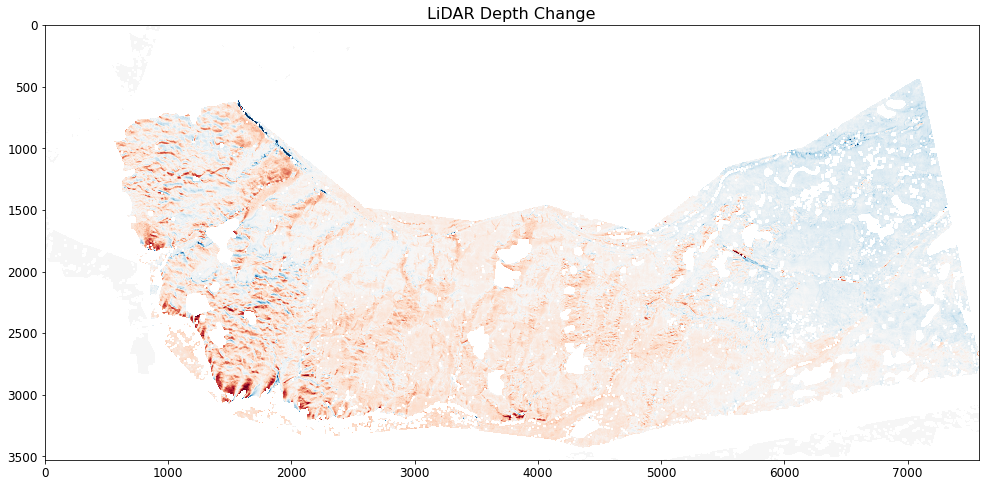

<AxesSubplot:title={'center':'LiDAR Depth Change'}>

In [29]:
# quick test plot
fig, ax = plt.subplots(figsize = (30,8))
ax.set_title("LiDAR Depth Change",fontsize = 16);
show((lidar_masked), cmap = 'RdBu', vmin = -.3, vmax = .3)

## LiDAR vs UNW
Using ```show_two_images()```, we can plot the LiDAR depth change and UNW images next to each other to compare them.

/srv/conda/envs/notebook/lib/python3.8/site-packages/matplotlib/colors.py:1202: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)


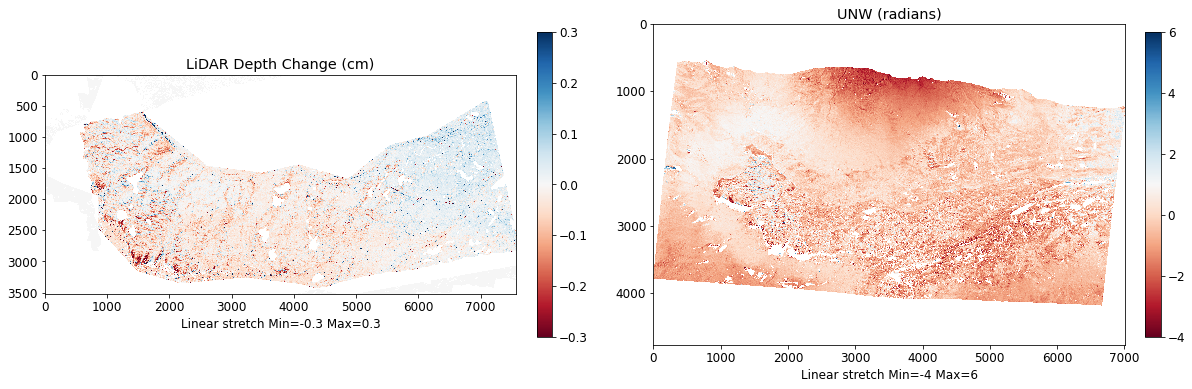

In [30]:
show_two_images(lidar_masked, unw_array, 'RdBu', 'RdBu', 'LiDAR Depth Change (cm)', 'UNW (radians)', vmin1 = -.3, vmax1 = .3, vmin2=-4, vmax2=6)

The two rasters cover different areas, are different resolutions, and have different missing pixels. Let's zoom into the top left corner of Grand Mesa where there was significant wind drifting to compare the two data sets.

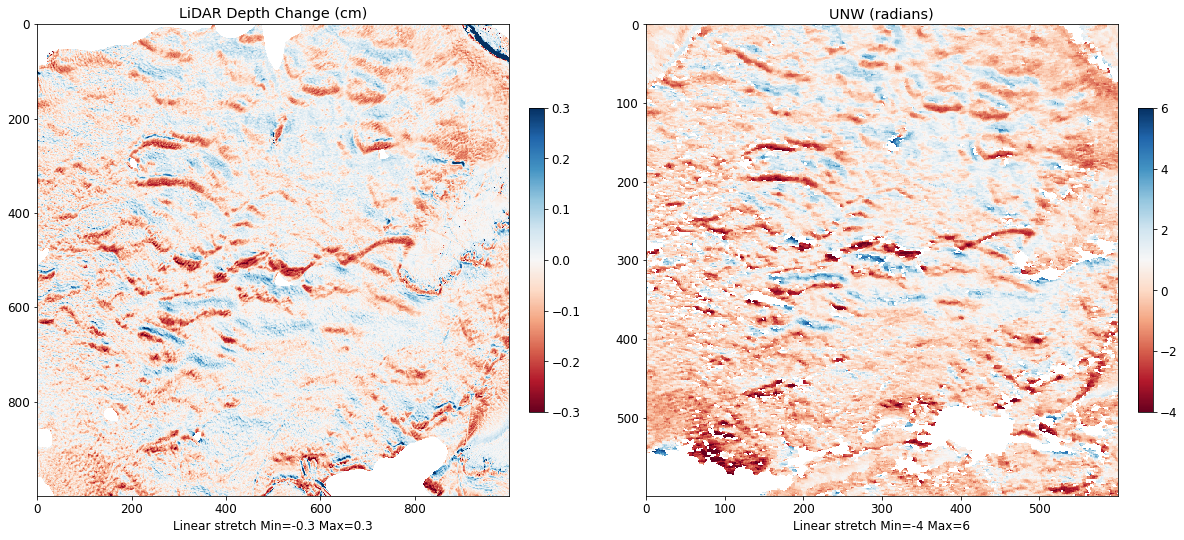

In [31]:
show_two_images(lidar_masked[700:1700,700:1700], unw_array[2150:2750,1300:1900], 
                'RdBu', 'RdBu', 'LiDAR Depth Change (cm)', 'UNW (radians)', vmin1 = -.3, vmax1 = .3, vmin2=-4, vmax2=6)

As you can see in the two plots above, there is a very strong spatial relationship between LiDAR depth change and InSAR change in phase. This relationship is the basis of measuring changes in SWE using L-band InSAR. While we don't get into the next step of converting phase change to SWE or depth change from InSAR, we will get into that in the UAVSAR project!